## Truncation Selection Simulations

In [2]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import pandas as pd
import scipy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [4]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In Drosophila, $V_A$ for fitness is approximately 0.01 (Santiago and Cabarello, 1998), so per chromosome.

In [6]:
genome = {'2':21089350+18979895, '3':22247347+26970900, '4':1104516, 'X': 20616142}

In [7]:
total = sum(genome.values())
chrom = (genome['3'])
chrom / total 
chrom / 1e6

49.218247

In [8]:
{k: 1.05 * v / total for k, v in genome.items()}

{'2': 0.37900557076214675,
 '3': 0.46554383034038493,
 '4': 0.010447357243589772,
 'X': 0.19500324165387858}

In [9]:
total * 3e-9

0.33302444999999997

In [10]:
def get_params(params):
    mu = float(params['mu']) 
    Vs = float(params['Vs'])
    rl = float(params['region_length'])
    alpha = float(params['alpha'])
    return mu, Vs, rl, alpha

def qgen_params(mu, Vs, region_length, alpha):
    U = mu * region_length  # per gamete
    HoC = 4 * Vs * U  # from Bulmer 1989
    GAA = np.sqrt(U * Vs * alpha**2)  # TODO check
    weak_mut = 20*U*Vs < alpha**2
    gaa_applicable = U * Vs > alpha**2
    print(f"weak mutation: {weak_mut}, GAA applicable: {gaa_applicable}")
    return HoC, GAA


The region length is 100e6 bp, and the mutation rate is


In [11]:
# ave_gene_len = 6e3
# ngens = 14e3
# coding = ave_gene_len * ngens
# prop_coding = coding / total
# rl = 50e6 * prop_coding
rl = 50e6
#mu = 1e-11
mu = 1e-7
N = 1000
U = 2 * mu * rl
alpha = 0.01
Vs = 1
rbp = 9e-9
print(f"map length = {rl * rbp} Morgans")
print(f"U = {U}")
print(f"trait θ = {np.round(4 * N * mu * rl, 1)}")
print(f"Va HoC = {4 * Vs * U}")
qgen_params(mu, Vs, rl, alpha)

map length = 0.44999999999999996 Morgans
U = 10.0
trait θ = 20000.0
Va HoC = 40.0
weak mutation: False, GAA applicable: True


(20.0, 0.022360679774997897)

In [12]:
stats = sf.parse_slim_stats('../data/sims/truncsel_1000N_0.5tail_rbp_0.05alpha_1e-07nmu_1e-07smu_2_stats.tsv')

In [13]:
qgen_params(*get_params(stats.params))

KeyError: 'mu'

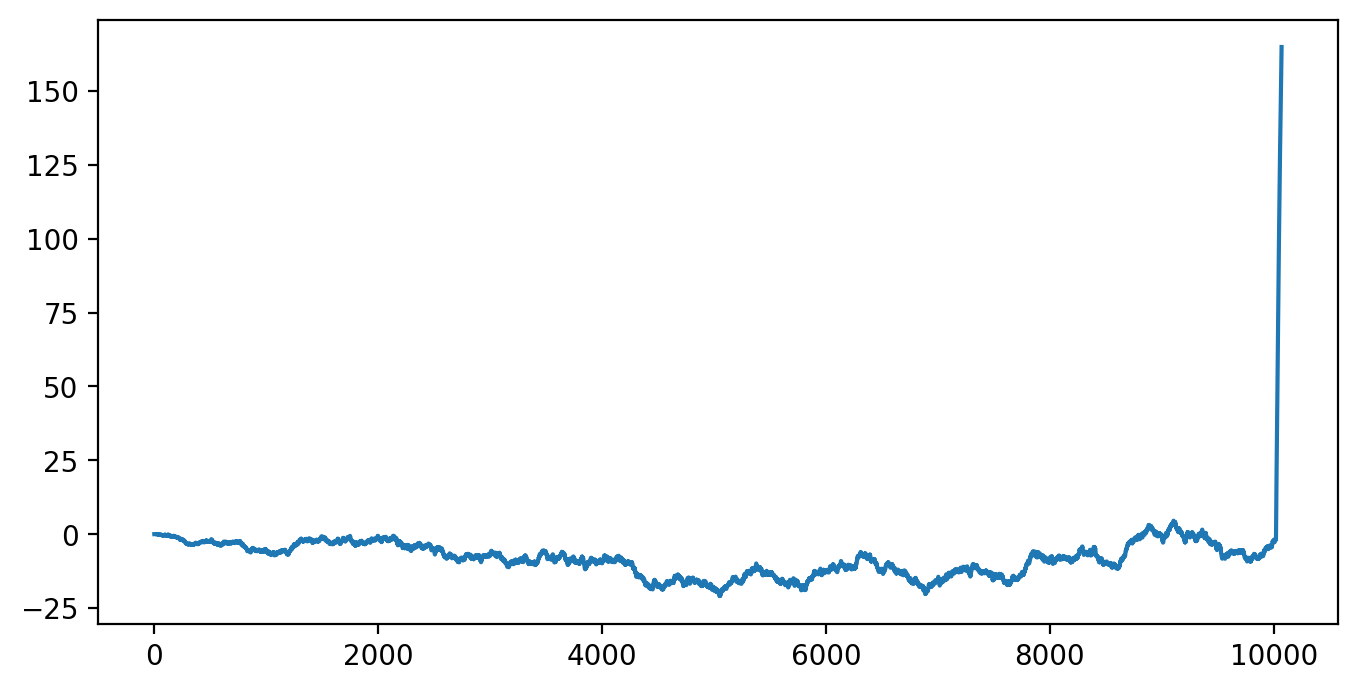

In [14]:
plt.plot(stats.stats['gen'], stats.stats['zbar'])
#plt.axhline(qgen_params(mu, Vs, rl, alpha)[1])
#plt.axhline(np.sqrt(4 * Vs * U))

Text(0.5, 0, 'generation')

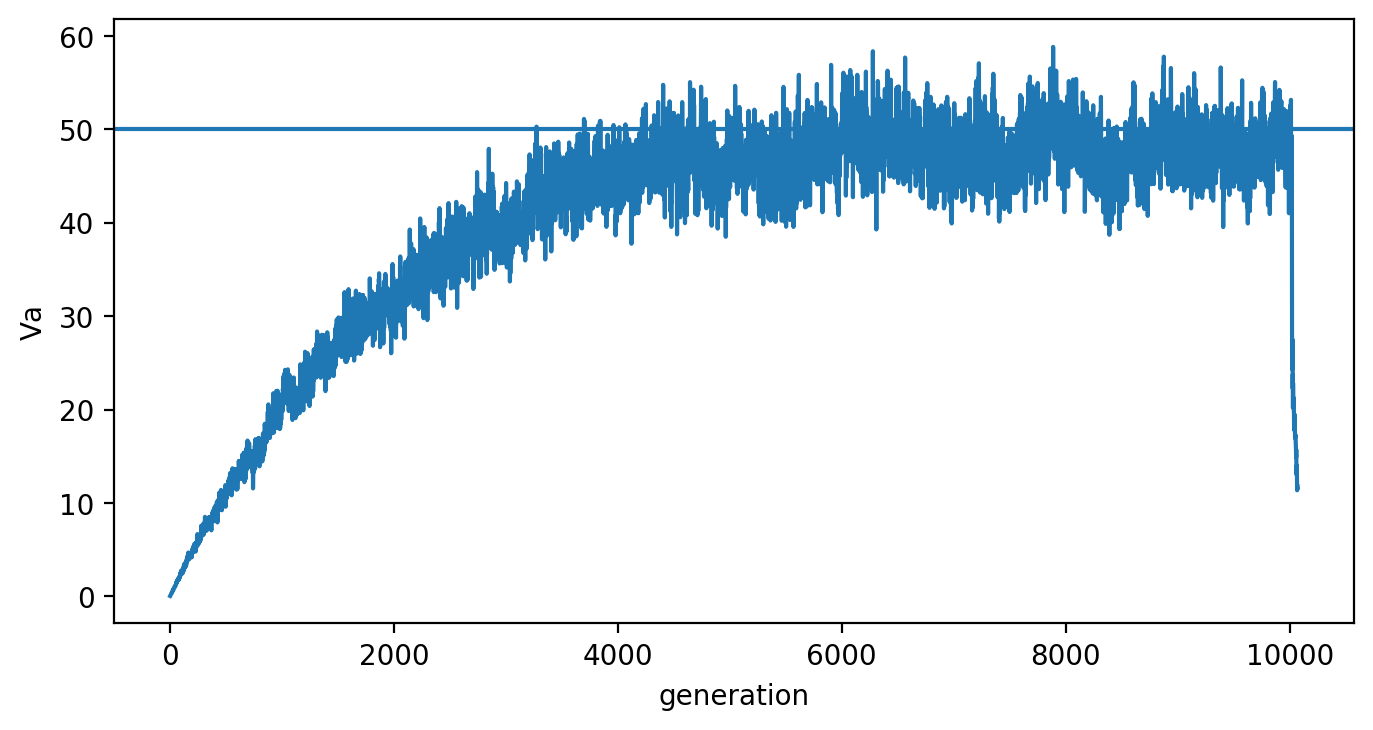

In [15]:
# plt.plot(stats.stats['gen'][10000:], stats.stats['zbar'][10000:])
plt.plot(stats.stats['gen'], stats.stats['zvar'])
plt.axhline(4e3 * 1e-7 *50e6 * 0.05**2)
plt.ylabel('Va')
plt.xlabel('generation')

Text(0.5, 0, 'generation')

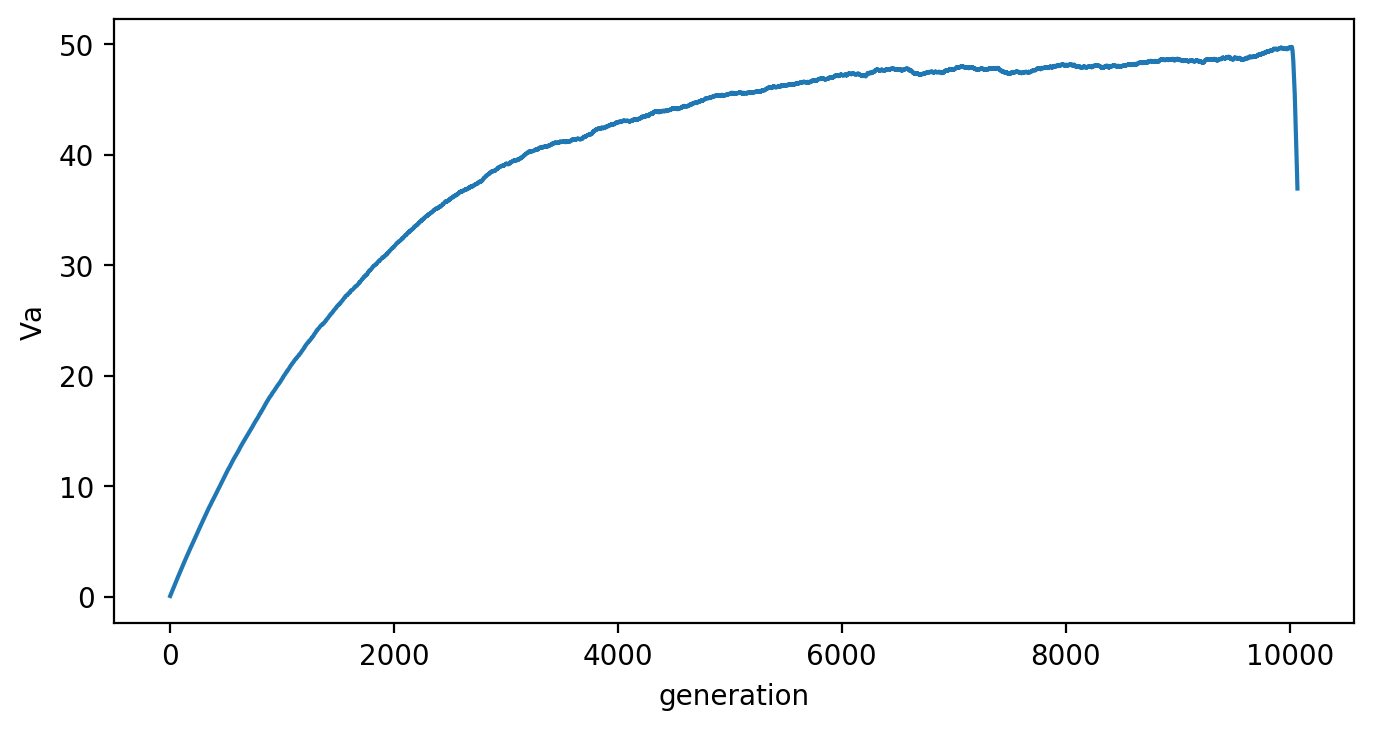

In [16]:
plt.plot(stats.stats['gen'], stats.stats['genic_var'])
#plt.axhline(4e3 * 1e-7 *50e6 * 0.05**2)
plt.ylabel('Va')
plt.xlabel('generation')

In [6]:
nfq = sf.parse_slim_ragged_freqs('../data/sims/truncsel_1000N_0.9tail_rbp_0.05alpha_1e-07nmu_1e-07smu_2_neutfreqs.tsv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/sims/truncsel_1000N_0.9tail_rbp_0.05alpha_1e-07nmu_1e-07smu_2_neutfreqs.tsv'

In [18]:
optimum_shift = 10020
before_gens = 20

idx = np.array([i for i, time in enumerate(nfq.samples) if optimum_shift - before_gens <= time])

samples = [(0, time) for time in idx]

d = TemporalFreqs(nfq.freqs[idx, :], samples)

In [19]:
dn = TemporalFreqs(nfq.freqs[idx, :], samples)
dn.freqs[np.logical_or(dn.freqs == 0, dn.freqs == 1)] = np.nan

In [23]:
covsn = dn.calc_cov(use_masked=True)

In [24]:
covs = d.calc_cov()

In [88]:
def ok71(r, N):
    R = 4*N*r
    return (5 + 2*R) / (11 + 26*R + 8*R**2)

def haldane(d):
    return 0.5*(1-np.exp(-2*d))

def bc19(va, R, N, t):
    integrand = lambda c: ok71(haldane(c), N) * (1-haldane(c))**t * 2*(R-c)/R**2
    ld = scipy.integrate.quad(integrand, 0, R)[0]
    return 0.5 * va * ld

Text(0.5, 0, 'generation')

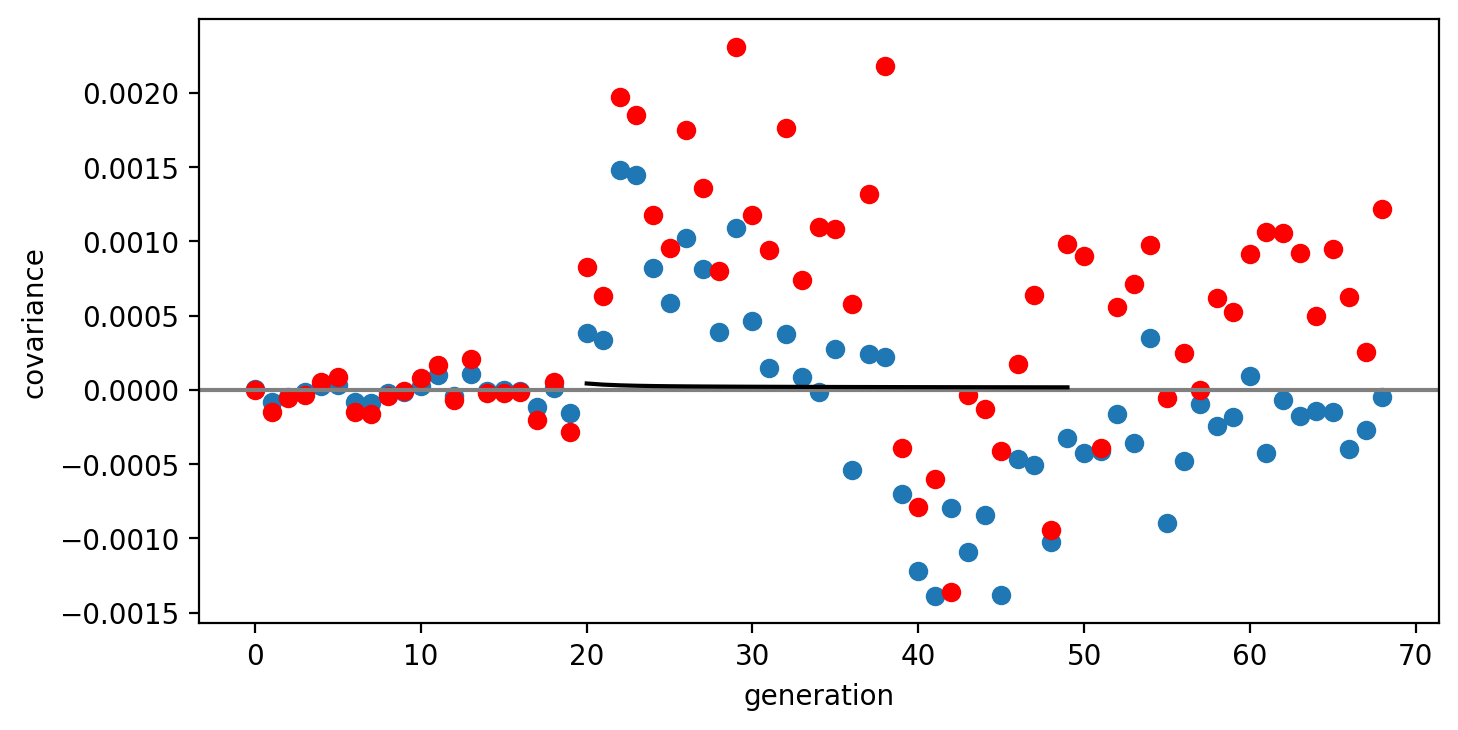

In [95]:
rbp = float(stats.params['rbp'])

ref = 23
fig, ax = plt.subplots(1, 1)
i = np.arange(covs.shape[0]) != ref
ax.plot(covs[ref, i], 'o')
ax.plot(covsn[ref, i], 'o', c='r')
ax.axhline(0, color='gray')
ax.plot(np.arange(20, 50), [bc19(0.25, rbp * rl, N, t) for t in np.arange(30)], color='k')
ax.set_ylabel('covariance')
ax.set_xlabel('generation')

In [104]:
g = d.calc_G()
gn = dn.calc_G(use_masked=True)

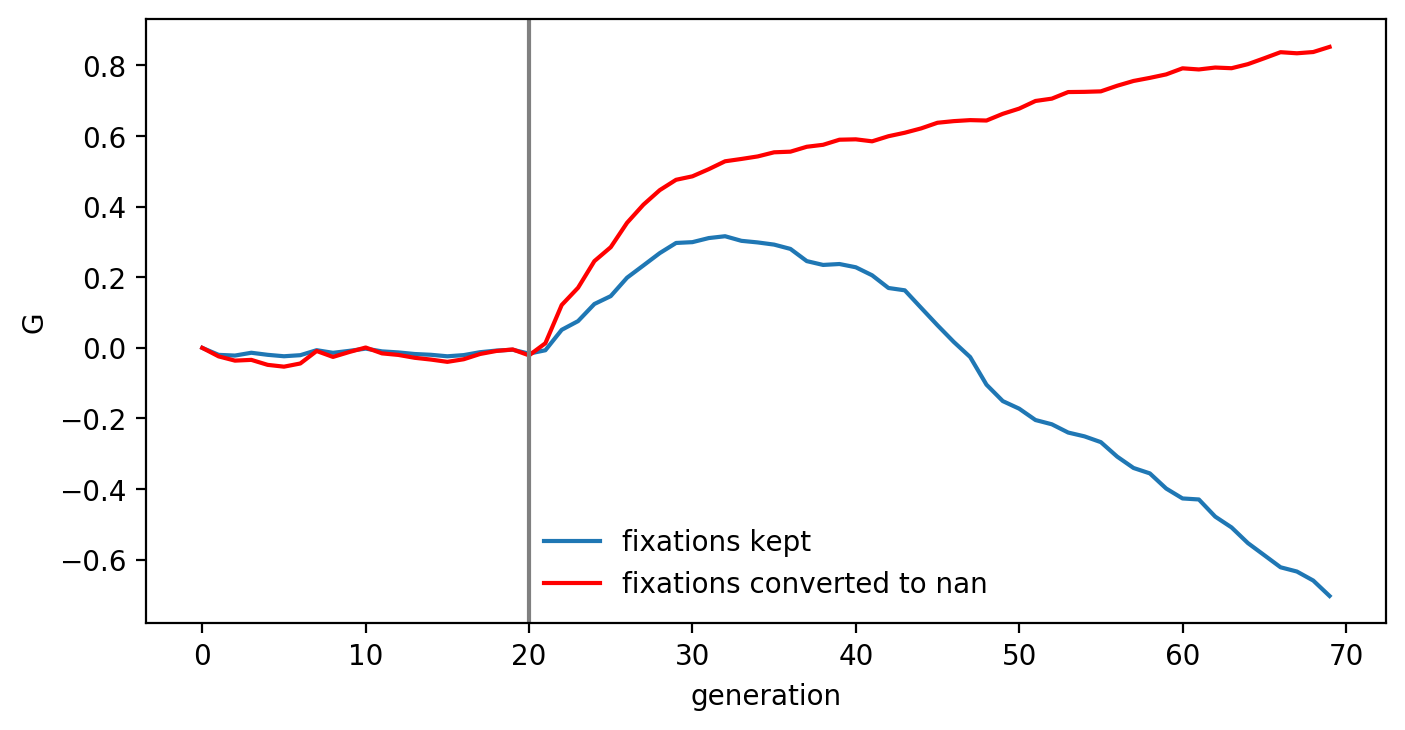

In [109]:
fig, ax = plt.subplots(1, 1)
ax.plot(g, label='fixations kept')
ax.plot(gn, c='r', label='fixations converted to nan')
ax.axvline(20, c='gray')

ax.set_ylabel('G')
ax.set_xlabel('generation')

ax.legend(frameon=False)


`Graham's notes:
 - truncation stabilizing selection to see if it generates covariances, maintain VA for fitness
 - changing number of loci, but keeping effect sizes the same —- is it insensitive to that? 
 - variance shift
 - slow optimum shift, burst shift
 - sliding window of G through time
 - linear fitness function